##### Name - Shunottara Alhat

# Assignment 16 - Q1 - Problem statement: predicting turbine energy yield (TEY) using ambient variables as features. (Gas Turbines)

##### Import Libraries

In [1]:
#pip install keras
#!pip install tuner
#!pip install keras-tuner
#!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
from imblearn.pipeline import Pipeline
from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
from keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

import warnings
warnings.filterwarnings('ignore')

##### Import Data

In [3]:
GasTurb = pd.read_csv("gas_turbines.csv")
GasTurb

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0      6.8594  1007.9  96.799  3.5000  19.663  1059.2  550.00  114.70  10.605   
1      6.7850  1008.4  97.118  3.4998  19.728  1059.3  550.00  114.72  10.598   
2      6.8977  1008.8  95.939  3.4824  19.779  1059.4  549.87  114.71  10.601   
3      7.0569  1009.2  95.249  3.4805  19.792  1059.6  549.99  114.72  10.606   
4      7.3978  1009.7  95.150  3.4976  19.765  1059.7  549.98  114.72  10.612   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
15034  9.0301  1005.6  98.460  3.5421  19.164  1049.7  546.21  111.61  10.400   
15035  7.8879  1005.9  99.093  3.5059  19.414  1046.3  543.22  111.78  10.433   
15036  7.2647  1006.3  99.496  3.4770  19.530  1037.7  537.32  110.19  10.483   
15037  7.0060  1006.8  99.008  3.4486  19.377  1043.2  541.24  110.74  10.533   
15038  6.9279  1007.2  97.533  3.4275  19.306  1049.9  545.85  111.58  10.583   

           CO     NOX  
0      3.1547  82.722  
1      3.2363  82.776  
2      3.2012  82.468  
3      3.1923  82.670  
4      3.2484  82.311  
...       ...     ...  
15034  4.5186  79.559  
15035  4.8470  79.917  
15036  7.9632  90.912  
15037  6.2494  93.227  
15038  4.9816  92.498  

[15039 rows x 11 columns]

## Explorary Data Analysis

In [4]:
# Info
GasTurb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [5]:
# Missing Value
GasTurb.isnull().any()

AT      False
AP      False
AH      False
AFDP    False
GTEP    False
TIT     False
TAT     False
TEY     False
CDP     False
CO      False
NOX     False
dtype: bool

In [6]:
# Shape
GasTurb.shape

(15039, 11)

In [7]:
#Checking the data types
GasTurb.dtypes

AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
NOX     float64
dtype: object

In [8]:
# Unique values for every feature
GasTurb.nunique()

AT      12086
AP        540
AH      12637
AFDP    11314
GTEP     8234
TIT       706
TAT      2340
TEY      4207
CDP      3611
CO      13096
NOX     11996
dtype: int64

In [9]:
# Duplicates
GasTurb.duplicated().sum()

0

In [10]:
# Describe
GasTurb.describe().T

count         mean        std          min          25%        50%  \
AT    15039.0    17.764381   7.574323     0.522300    11.408000    18.1860   
AP    15039.0  1013.199240   6.410760   985.850000  1008.900000  1012.8000   
AH    15039.0    79.124174  13.793439    30.344000    69.750000    82.2660   
AFDP  15039.0     4.200294   0.760197     2.087400     3.723900     4.1862   
GTEP  15039.0    25.419061   4.173916    17.878000    23.294000    25.0820   
TIT   15039.0  1083.798770  16.527806  1000.800000  1079.600000  1088.7000   
TAT   15039.0   545.396183   7.866803   512.450000   542.170000   549.8900   
TEY   15039.0   134.188464  15.829717   100.170000   127.985000   133.7800   
CDP   15039.0    12.102353   1.103196     9.904400    11.622000    12.0250   
CO    15039.0     1.972499   2.222206     0.000388     0.858055     1.3902   
NOX   15039.0    68.190934  10.470586    27.765000    61.303500    66.6010   

            75%        max  
AT      23.8625    34.9290  
AP    1016.9000  1034.2000  
AH      90.0435   100.2000  
AFDP     4.5509     7.6106  
GTEP    27.1840    37.4020  
TIT   1096.0000  1100.8000  
TAT    550.0600   550.6100  
TEY    140.8950   174.6100  
CDP     12.5780    15.0810  
CO       2.1604    44.1030  
NOX     73.9355   119.8900

In [11]:
# Correlation
GasTurb.corr()["TEY"].sort_values(ascending = False)

TEY     1.000000
CDP     0.988473
GTEP    0.977042
TIT     0.891587
AFDP    0.717995
AP      0.146939
NOX    -0.102631
AH     -0.110272
AT     -0.207495
CO     -0.541751
TAT    -0.720356
Name: TEY, dtype: float64

In [12]:
Numerical_features = GasTurb.describe(include=["int64","float64"]).columns
Numerical_features

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

## Data Visualization 

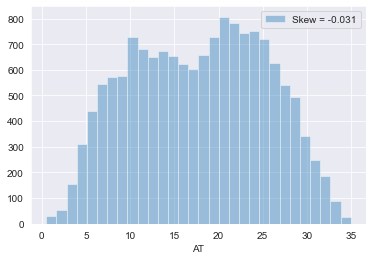

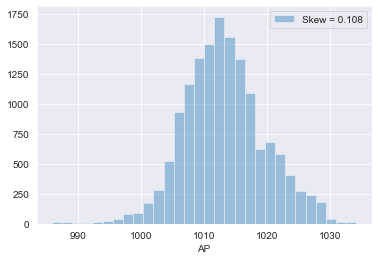

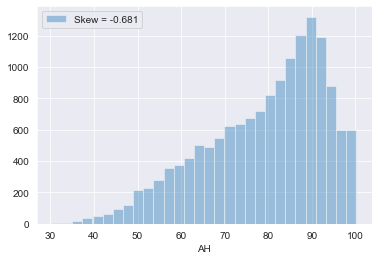

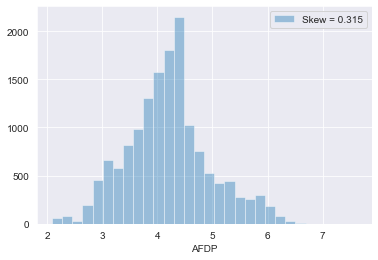

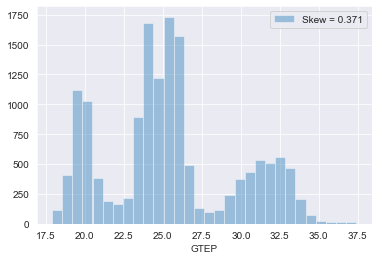

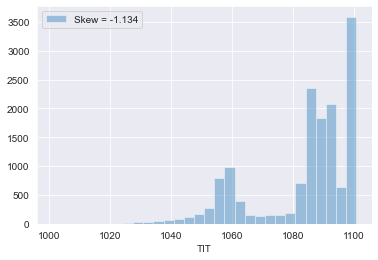

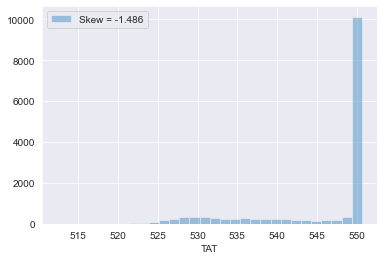

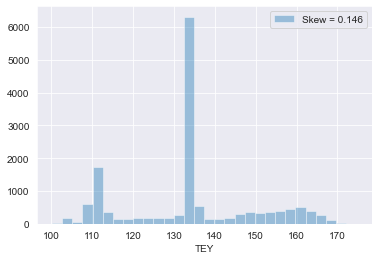

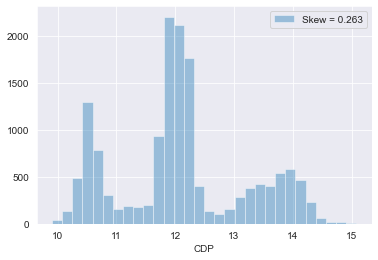

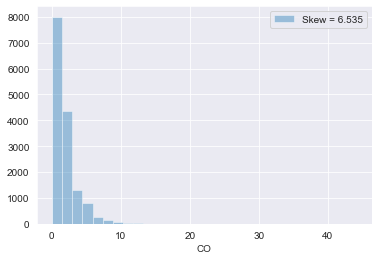

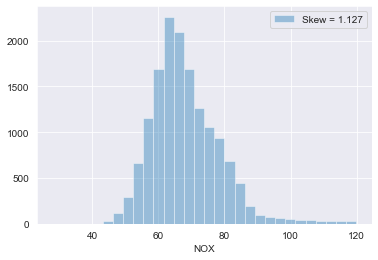

In [13]:
Numerical_features=[feature for feature in GasTurb.columns if GasTurb[feature].dtypes != 'O']
for feat in Numerical_features:
    skew = GasTurb[feat].skew()
    sns.distplot(GasTurb[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [14]:
# Detect observations with more than one outlier

def outlier_hunt(GasTurb):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in GasTurb.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(GasTurb[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(GasTurb[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = GasTurb[(GasTurb[col] < Q1 - outlier_step) | (GasTurb[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(GasTurb[Numerical_features])))) 

The dataset contains 1543 observations with more than 2 outliers


In [15]:
Numerical_features

['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO', 'NOX']

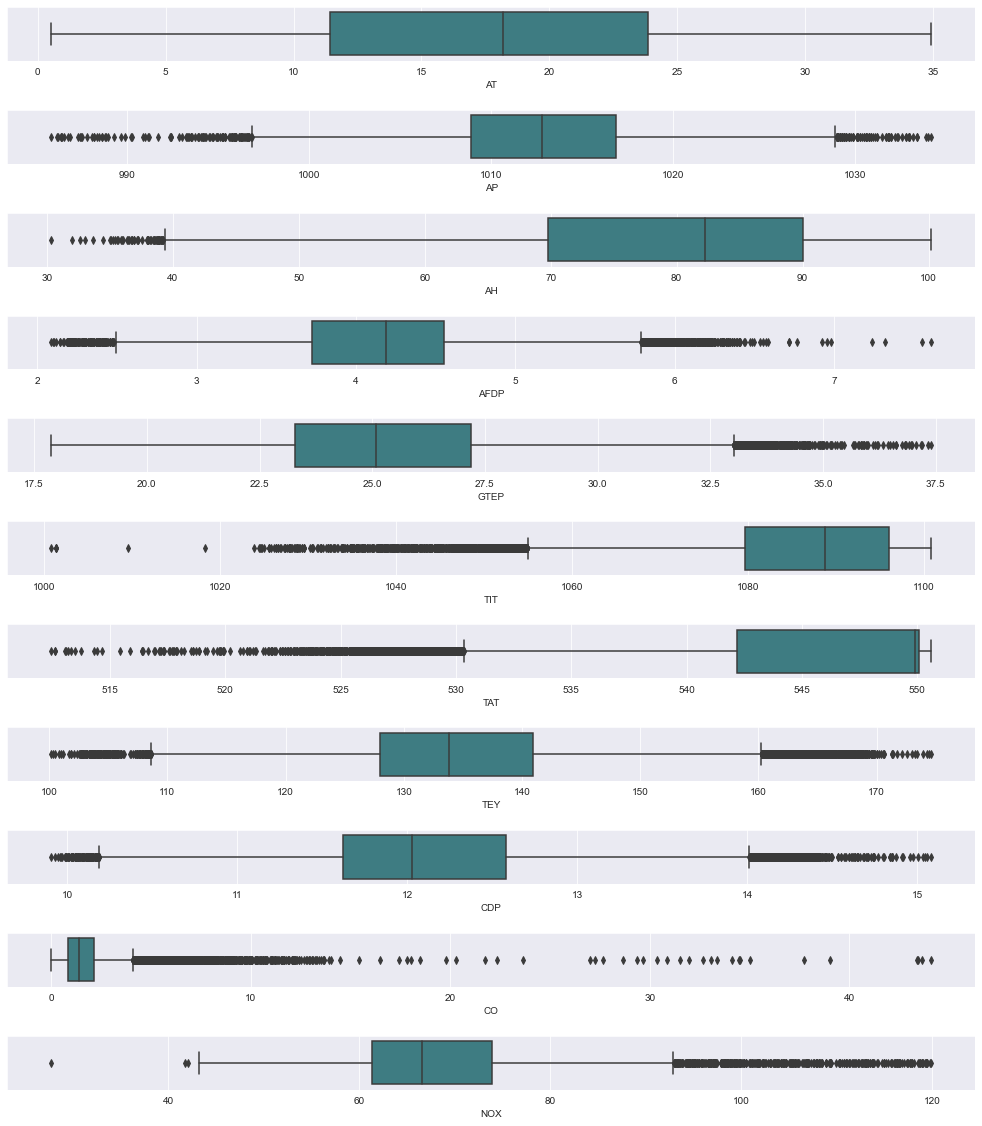

In [16]:
# OT is Outlier

OT = GasTurb.copy() 
fig, axes=plt.subplots(11,1,figsize=(14,16),sharex=False,sharey=False)
sns.boxplot(x='AT',data= OT,palette='crest',ax=axes[0])
sns.boxplot(x='AP',data= OT,palette='crest',ax=axes[1])
sns.boxplot(x='AH',data= OT,palette='crest',ax=axes[2])
sns.boxplot(x='AFDP',data= OT,palette='crest',ax=axes[3])
sns.boxplot(x='GTEP',data= OT,palette='crest',ax=axes[4])
sns.boxplot(x='TIT',data= OT,palette='crest',ax=axes[5])
sns.boxplot(x='TAT',data= OT,palette='crest',ax=axes[6])
sns.boxplot(x='TEY',data= OT,palette='crest',ax=axes[7])
sns.boxplot(x='CDP',data= OT,palette='crest',ax=axes[8])
sns.boxplot(x='CO',data= OT,palette='crest',ax=axes[9])
sns.boxplot(x='NOX',data= OT,palette='crest',ax=axes[10])
plt.tight_layout(pad=2.0)

<AxesSubplot:>

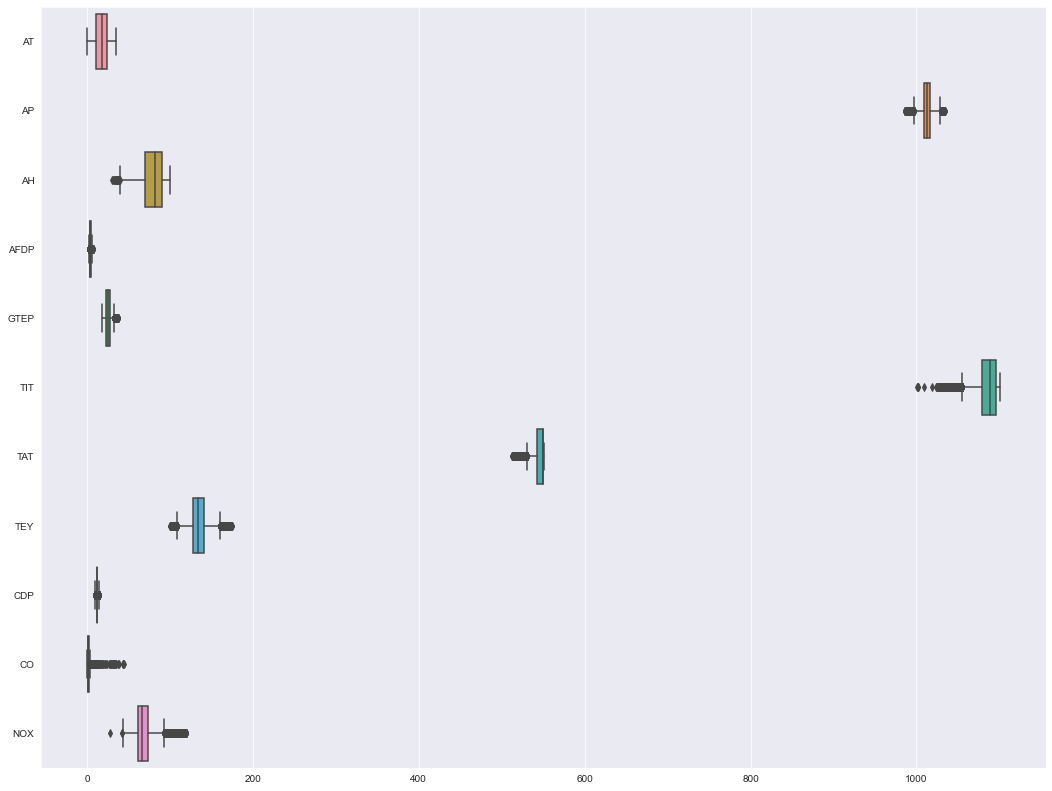

In [17]:
#outlier
plt.figure(figsize=(18,14))
sns.boxplot(data= GasTurb[Numerical_features], orient="h")

Text(0.5, 1.0, 'Histogram of the Target Column')

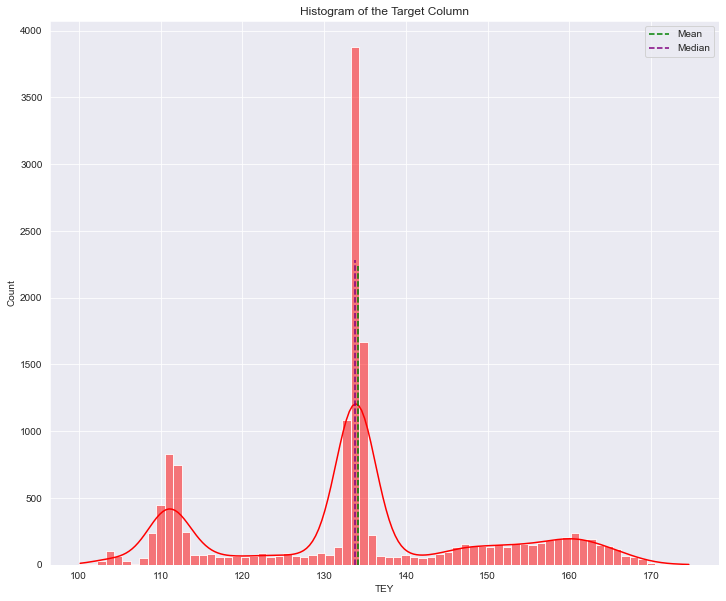

In [18]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,10))
sns.histplot(data= GasTurb,x="TEY",color="red",kde=True)
plt.axvline(x= GasTurb["TEY"].mean(),ymax=0.55,color="green",linestyle='--',label="Mean")
plt.axvline(x= GasTurb["TEY"].median(),ymax=0.56,color="purple",linestyle='--',label="Median")
plt.legend()
plt.title("Histogram of the Target Column")

Text(0.5, 1.0, 'Cumulative of the Target Column')

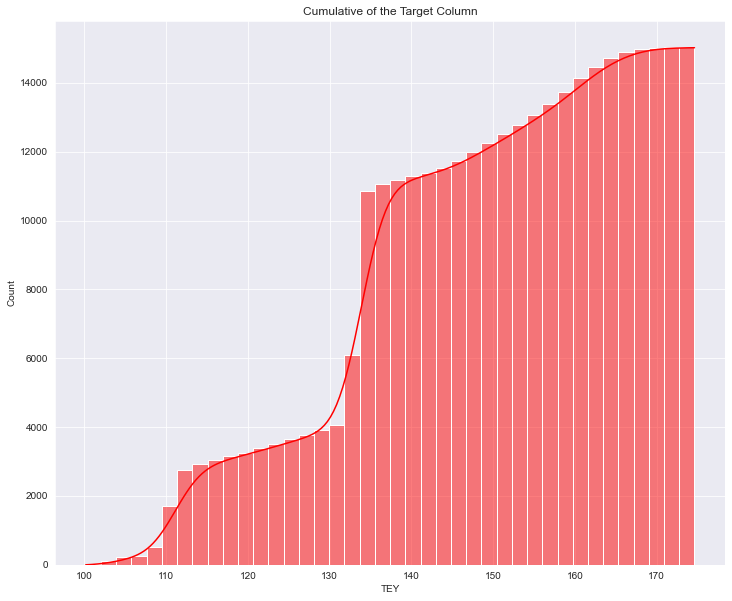

In [19]:
plt.figure(figsize = (12,10))
sns.histplot(GasTurb["TEY"],kde=True,bins=40,color="red",cumulative=True)
plt.title("Cumulative of the Target Column")

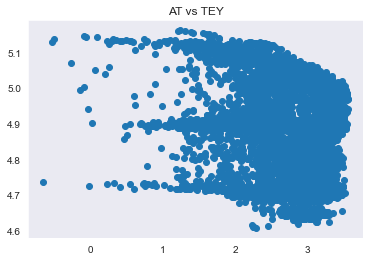

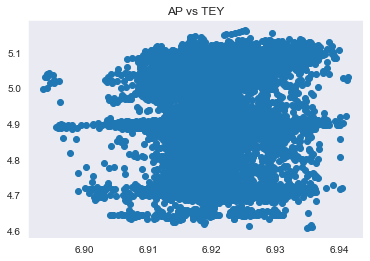

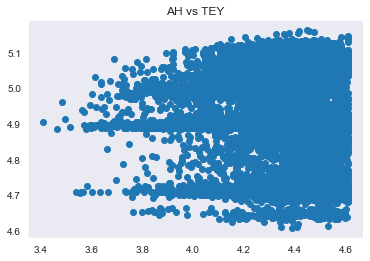

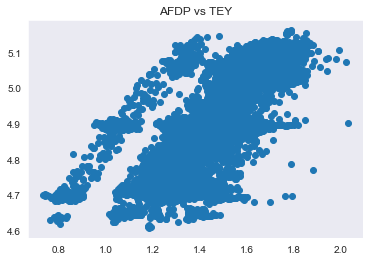

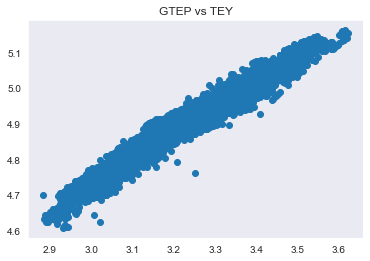

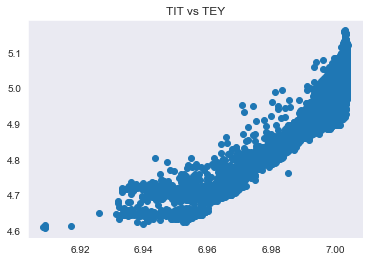

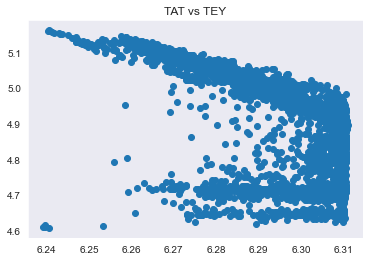

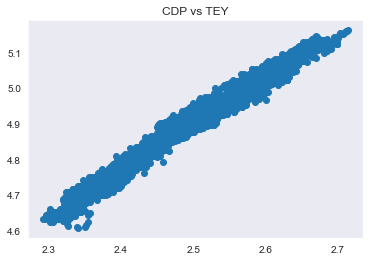

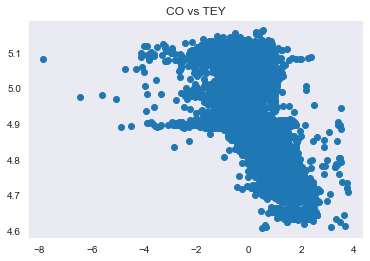

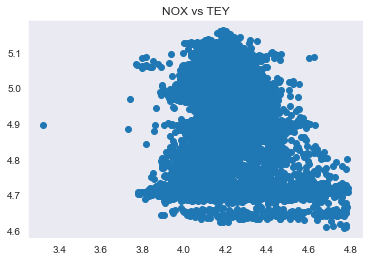

In [20]:
for i in GasTurb.columns:
    if i!="TEY": 
        plt.scatter(np.log(GasTurb[i]), np.log(GasTurb['TEY']))
        plt.title(i+ ' vs TEY')
        plt.grid()
        plt.show()

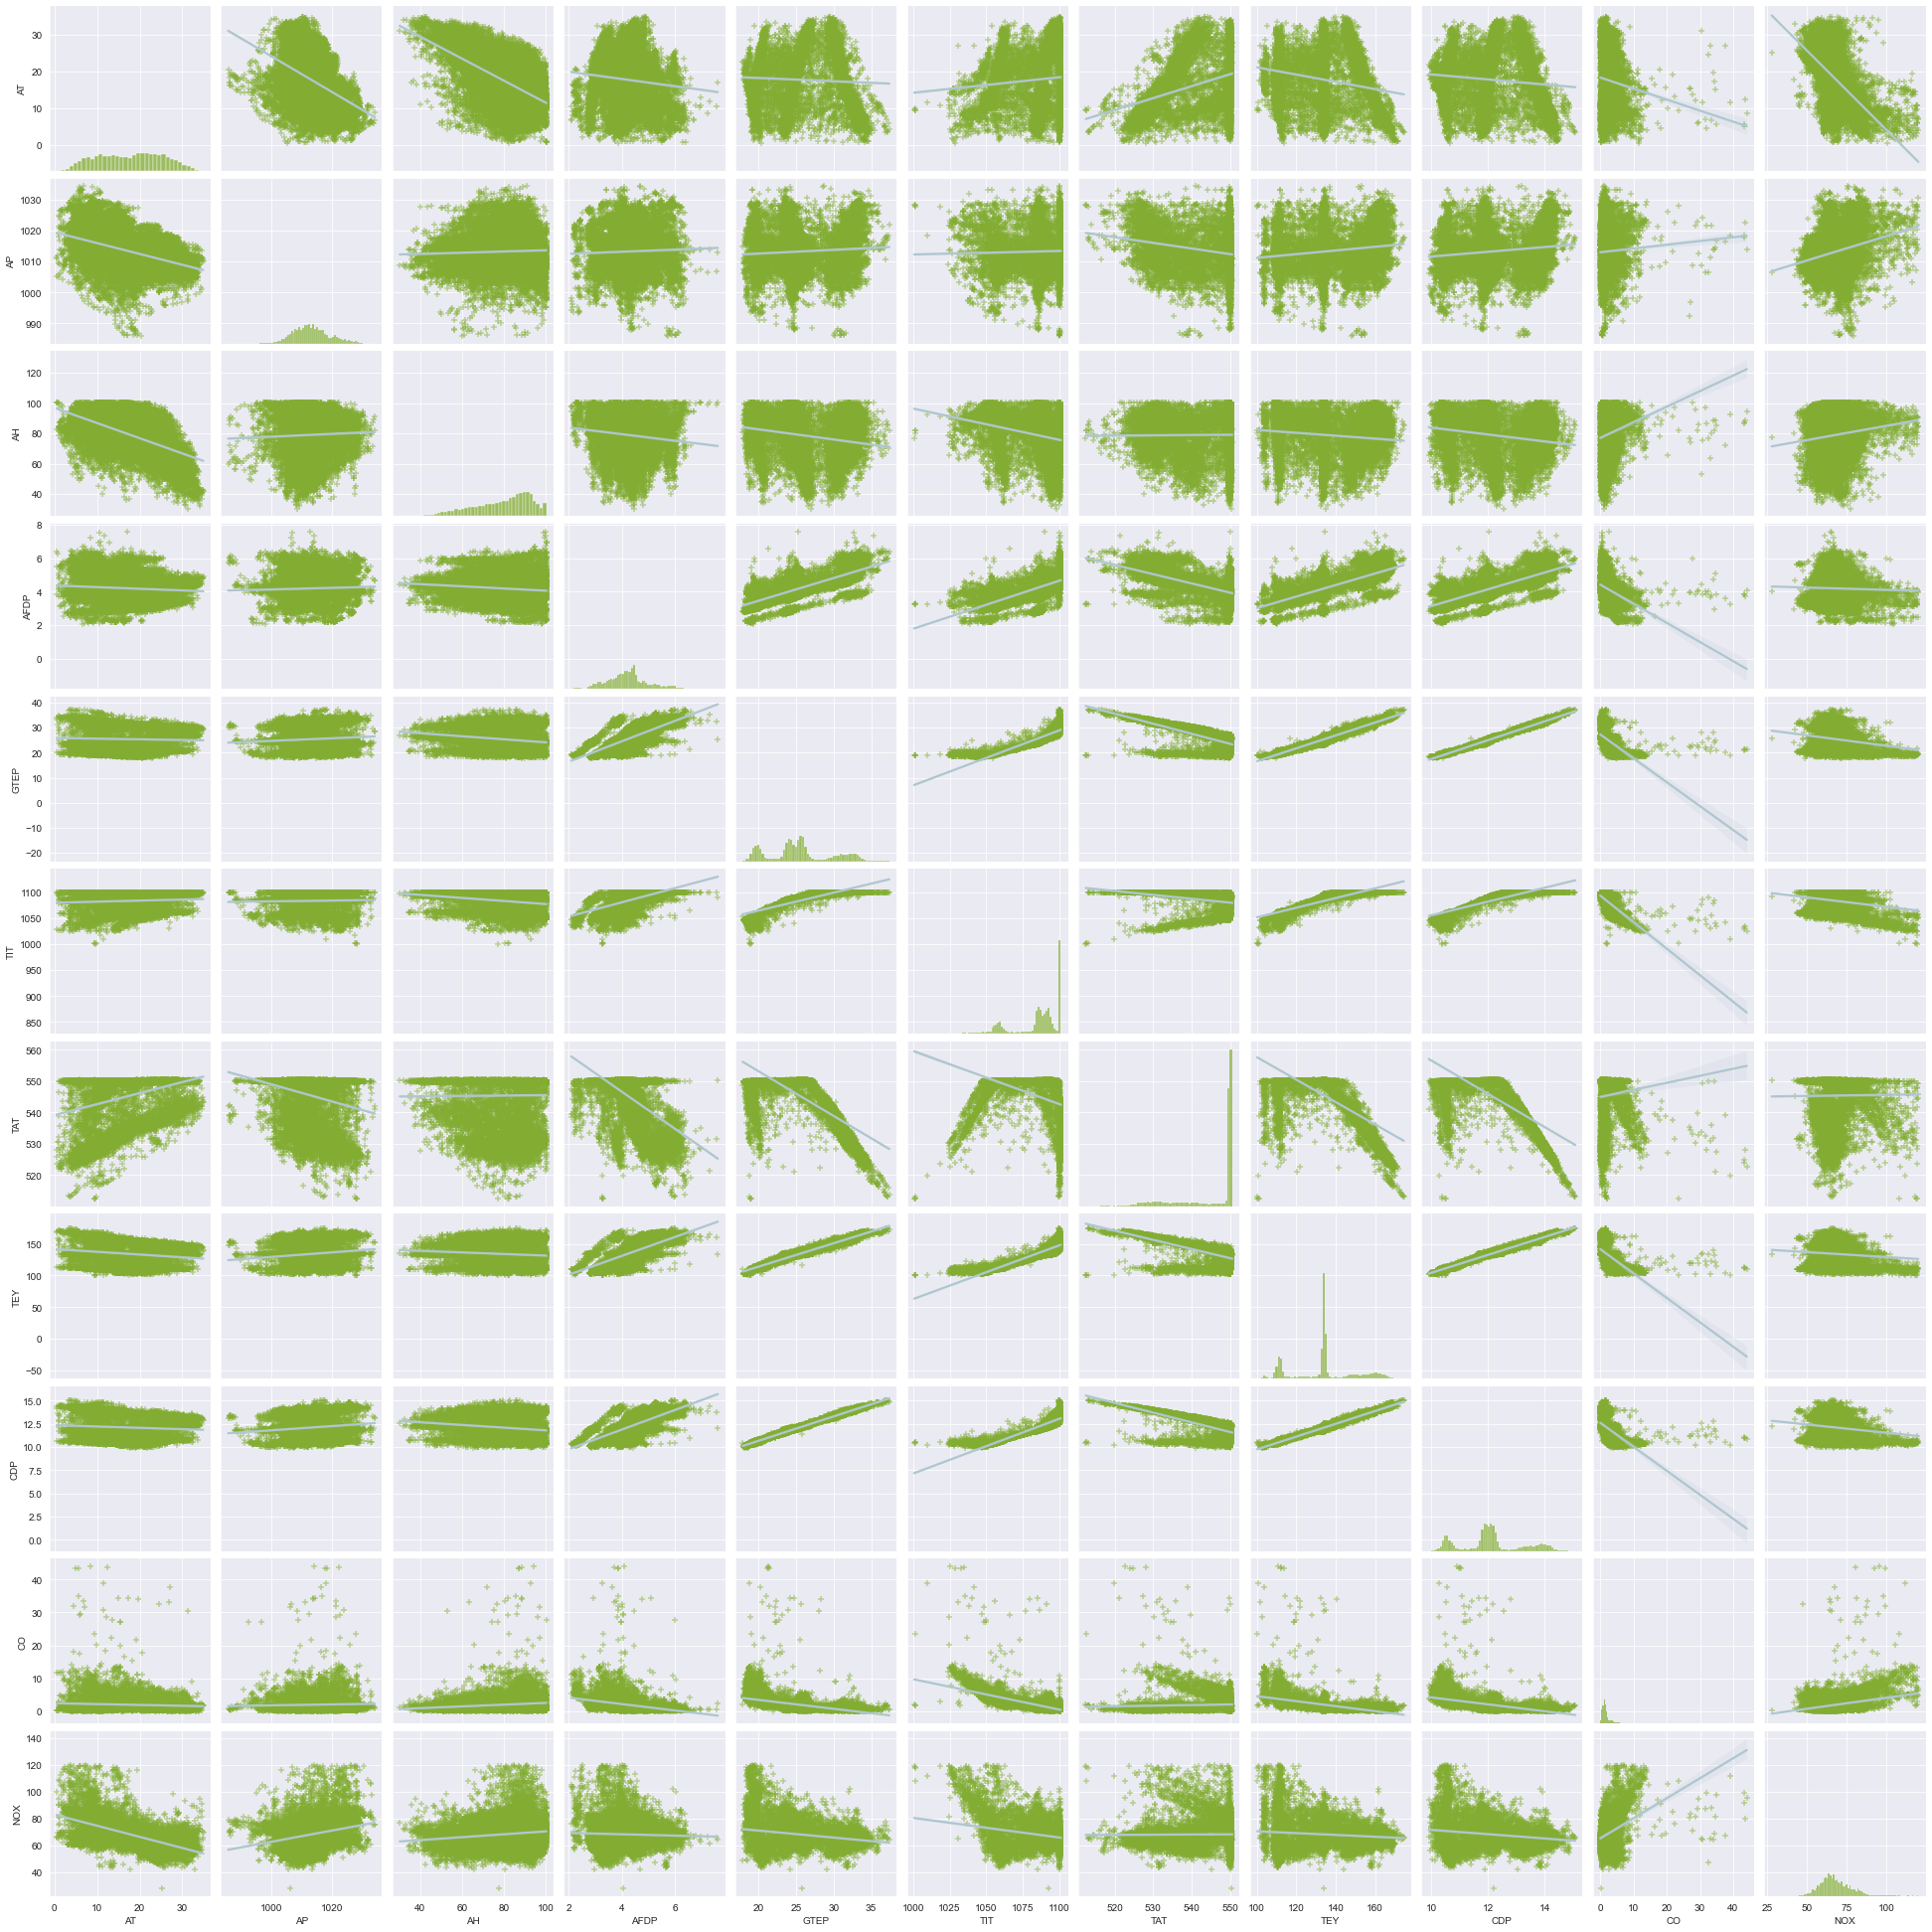

In [21]:
sns.pairplot(GasTurb, markers="+",kind='reg',diag_kind="auto",
                 plot_kws={'line_kws':{'color':'#aec6cf'},'scatter_kws': {'alpha': 0.5,
                                           'color': '#82ad32'}},
               
                 diag_kws= {'color': '#82ad32'})

<Figure size 1440x1440 with 0 Axes>

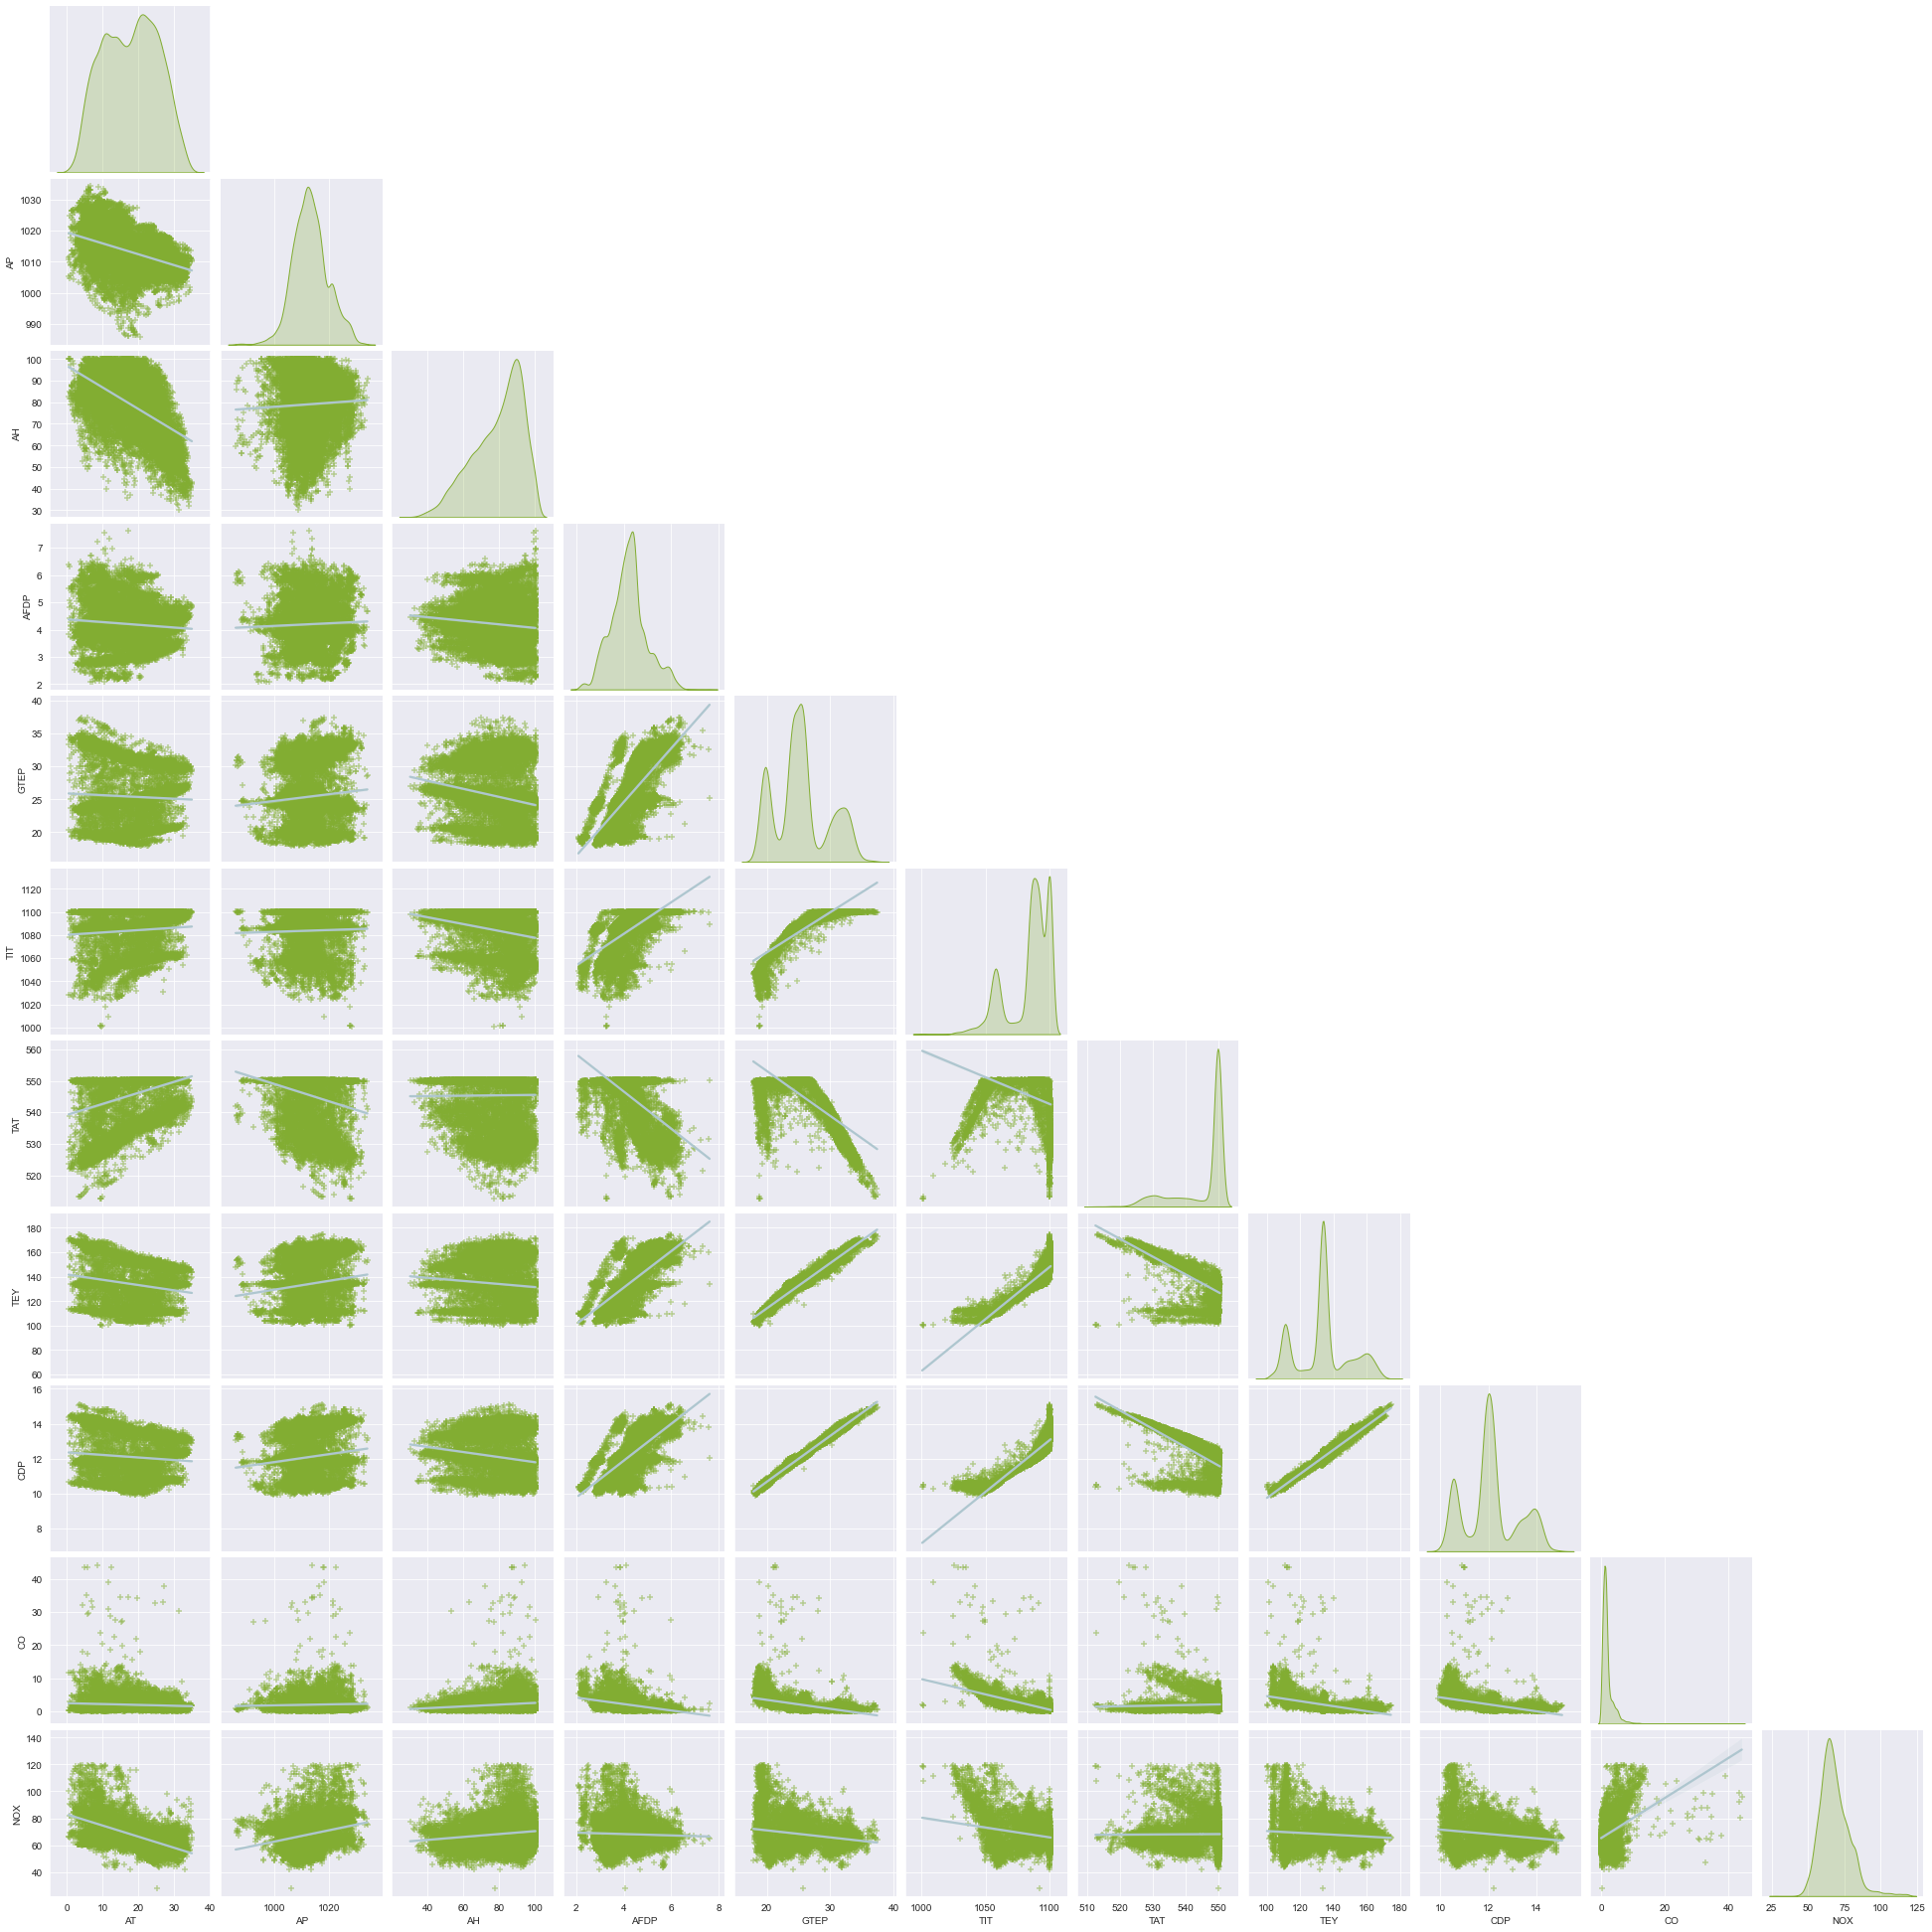

In [22]:
plt.figure(figsize=(20,20))
sns.pairplot(GasTurb,markers="+",kind='reg',diag_kind="kde",
                 plot_kws={'line_kws':{'color':'#aec6cf'},'scatter_kws': {'alpha': 0.5,
                                           'color': '#82ad32'}},
               corner=True,
                 diag_kws= {'color': '#82ad32'})

<AxesSubplot:>

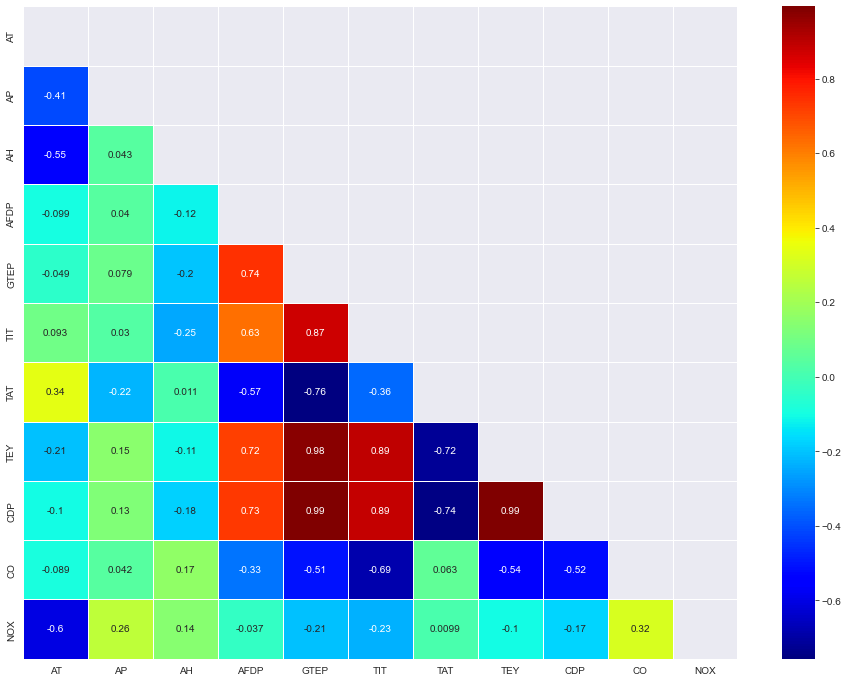

In [23]:
# Having a look at the correlation matrix

plt.figure(figsize=(16,12))
mask = np.zeros_like(GasTurb.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data= GasTurb.corr(), cmap="jet", annot=True,linewidths=1, linecolor='white',mask=mask)

In [24]:
x = GasTurb.drop('TEY', axis=1)
y = GasTurb[["TEY"]]

Text(0.5, 1.0, 'Correlation with Turbine Energy Yield \n')

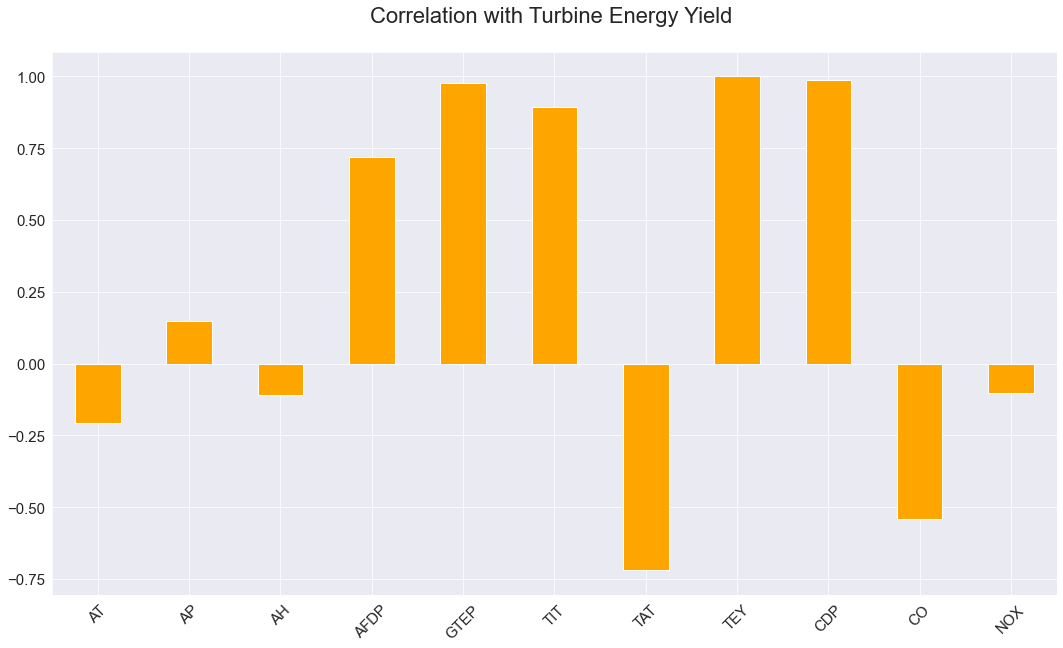

In [25]:
Data2 = GasTurb.copy()

correlations = Data2.corrwith(GasTurb.TEY)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar( figsize = (18, 10), fontsize = 15, color = 'orange',rot = 45, grid = True)
plt.title('Correlation with Turbine Energy Yield \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

#### Feature Selection Technique 

In [26]:
# feature extraction
Test = SelectKBest(score_func= mutual_info_regression, k='all')
fit = Test.fit(x, y)

In [27]:
# summarize scores
scores = fit.scores_

features = fit.transform(x)

In [28]:
score_df = pd.DataFrame(list(zip(scores, x.columns)),columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

Score Feature
7  1.712962     CDP
4  1.599950    GTEP
5  1.324133     TIT
6  0.898765     TAT
3  0.660718    AFDP
8  0.512537      CO
0  0.412185      AT
9  0.300768     NOX
1  0.139013      AP
2  0.097490      AH

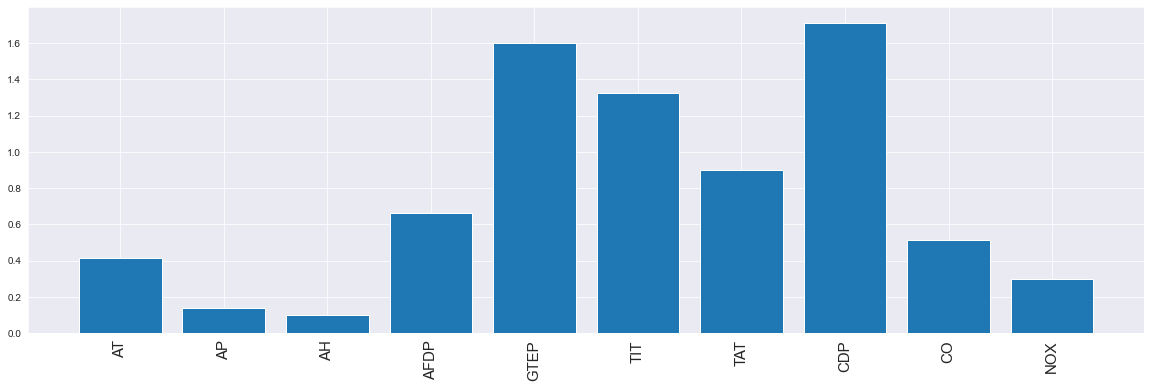

In [29]:
fig, axes = plt.subplots(figsize=(20, 6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

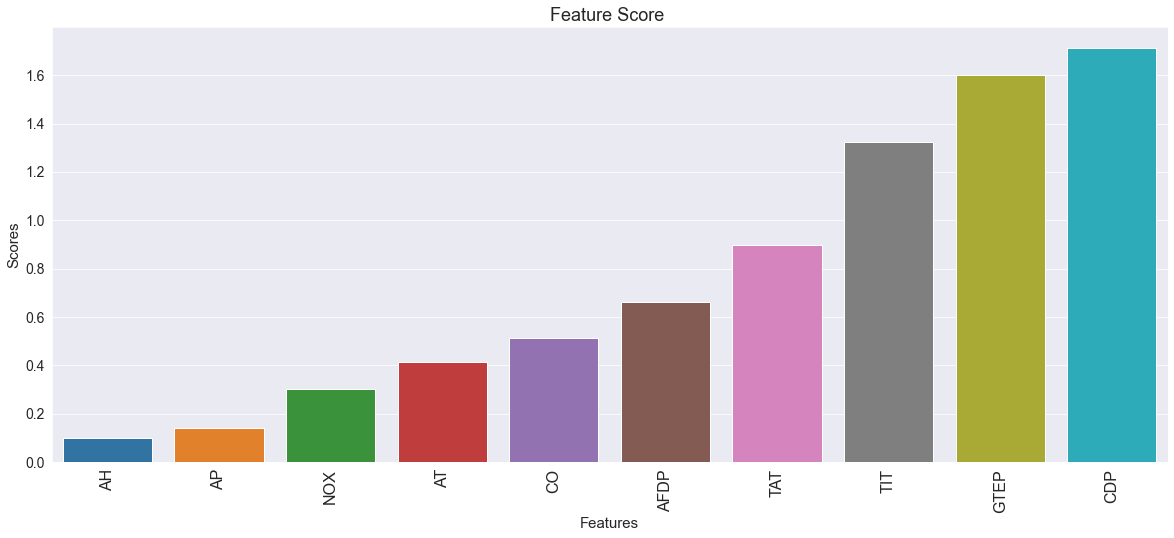

In [30]:
plt.figure(figsize=(20,8))
# make barplot and sort bars
sns.barplot(x='Feature',y="Score", data= score_df, order=score_df.sort_values('Score').Feature)

# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score ", size=18)
plt.show()

In [31]:
score_df.sort_values('Score',ascending=False)

Score Feature
7  1.712962     CDP
4  1.599950    GTEP
5  1.324133     TIT
6  0.898765     TAT
3  0.660718    AFDP
8  0.512537      CO
0  0.412185      AT
9  0.300768     NOX
1  0.139013      AP
2  0.097490      AH

In [32]:
model_data = GasTurb[['CDP', 'GTEP','TIT', 'TAT', 'AFDP', 'CO', 'AT',"TEY"]]
model_data.head()

CDP    GTEP     TIT     TAT    AFDP      CO      AT     TEY
0  10.605  19.663  1059.2  550.00  3.5000  3.1547  6.8594  114.70
1  10.598  19.728  1059.3  550.00  3.4998  3.2363  6.7850  114.72
2  10.601  19.779  1059.4  549.87  3.4824  3.2012  6.8977  114.71
3  10.606  19.792  1059.6  549.99  3.4805  3.1923  7.0569  114.72
4  10.612  19.765  1059.7  549.98  3.4976  3.2484  7.3978  114.72

### Data Pre-Processing 

In [33]:
continuous_feature=[feature for feature in model_data.columns if model_data[feature].dtype!='O']
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 8


In [34]:
df_standard_scaled = model_data.copy()
features = df_standard_scaled[continuous_feature]

In [35]:
scaler = StandardScaler()

df_standard_scaled[continuous_feature] = scaler.fit_transform(features.values)
df_standard_scaled.head()

CDP      GTEP       TIT       TAT      AFDP        CO        AT  \
0 -1.357331 -1.379101 -1.488376  0.585240 -0.921232  0.532012 -1.439778   
1 -1.363676 -1.363528 -1.482325  0.585240 -0.921495  0.568733 -1.449601   
2 -1.360957 -1.351309 -1.476275  0.568715 -0.944385  0.552938 -1.434721   
3 -1.356424 -1.348194 -1.464173  0.583969 -0.946884  0.548933 -1.413702   
4 -1.350985 -1.354663 -1.458123  0.582698 -0.924389  0.574179 -1.368693   

        TEY  
0 -1.231172  
1 -1.229909  
2 -1.230541  
3 -1.229909  
4 -1.229909

#### Now if we check the mean and standard deviation of our scaled data it should have a Mean '0' and Standard deviation '1' 

In [36]:
print('Mean' '\n',np.round(df_standard_scaled.mean(),1),'\n' 'Standard Devaition','\n',np.round(df_standard_scaled.std()),1)

Mean
 CDP     0.0
GTEP    0.0
TIT    -0.0
TAT     0.0
AFDP    0.0
CO      0.0
AT     -0.0
TEY     0.0
dtype: float64 
Standard Devaition 
 CDP     1.0
GTEP    1.0
TIT     1.0
TAT     1.0
AFDP    1.0
CO      1.0
AT      1.0
TEY     1.0
dtype: float64 1


### Test Train Split 

In [37]:
x = df_standard_scaled.drop('TEY',axis=1)
y = df_standard_scaled[['TEY']]

In [38]:
# Splitting data into test data and train data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)

## Hyperparameter Tuning 

In [39]:
# Optimal Learning rate ,Number of Layers and Neurons

def build_model(hp):
    model =Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=100,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [40]:
Tuner = RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=5,  executions_per_trial=3,
                     directory='project',project_name='Gas Turbine')

Reloading Oracle from existing project project\Gas Turbine\oracle.json
Reloading Tuner from project\Gas Turbine\tuner0.json


In [41]:
Tuner.search_space_summary()

Search space summary
Default search space size: 15
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_6 (Int)
{'default': None, 'co

In [42]:
Tuner.search(x_train, y_train,epochs= 100,validation_data=(x_test, y_test))

Oracle triggered exit


In [43]:
Tuner.results_summary()

Results summary
Results in project\Gas Turbine
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 10
units_0: 96
units_1: 96
learning_rate: 0.001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
Score: 0.028955842057863872
Trial summary
Hyperparameters:
num_layers: 13
units_0: 64
units_1: 32
learning_rate: 0.001
units_2: 64
units_3: 64
units_4: 64
units_5: 32
units_6: 64
units_7: 64
units_8: 64
units_9: 96
units_10: 64
units_11: 64
units_12: 32
Score: 0.0397138757010301
Trial summary
Hyperparameters:
num_layers: 5
units_0: 64
units_1: 64
learning_rate: 0.0001
units_2: 96
units_3: 64
units_4: 96
units_5: 64
units_6: 64
units_7: 64
units_8: 64
units_9: 64
Score: 0.04232528184851011
Trial summary
Hyperparameters:
num_layers: 12
units_0: 96
units_1: 32
learning_rate: 0.01
units_2: 32
units_3: 64
units_4: 32
units_5: 96
units_6: 96
units_7: 64
units_8: 96
units_9: 32
units_10: 32
units_11: 32
Score: 0.0969946173330148
Trial summa

In [44]:
# Optimal Batch_size, Number of Epochs

def create_model():
    model1 = Sequential()
    model1.add(Dense(32,input_dim=7,activation='relu'))
    model1.add(Dense(64,activation='relu'))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(units=1,activation="linear"))
    
    adam= Adam(learning_rate=0.001)
    model1.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model1

In [45]:
model1 =KerasRegressor(build_fn=create_model,verbose=0)
batch_size=[10]
epochs=[10,50]
param_grid=dict(batch_size=batch_size,epochs=epochs)
grid = GridSearchCV(estimator=model1,param_grid=param_grid,cv=KFold(),verbose=10)

In [46]:
grid_result = grid.fit(x_test,y_test)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START batch_size=10, epochs=10....................................
[CV 1/5; 1/2] END ....batch_size=10, epochs=10;, score=-0.054 total time=   8.1s
[CV 2/5; 1/2] START batch_size=10, epochs=10....................................
[CV 2/5; 1/2] END ....batch_size=10, epochs=10;, score=-0.053 total time=   4.8s
[CV 3/5; 1/2] START batch_size=10, epochs=10....................................
[CV 3/5; 1/2] END ....batch_size=10, epochs=10;, score=-0.066 total time=   4.6s
[CV 4/5; 1/2] START batch_size=10, epochs=10....................................
[CV 4/5; 1/2] END ....batch_size=10, epochs=10;, score=-0.034 total time=   4.5s
[CV 5/5; 1/2] START batch_size=10, epochs=10....................................
[CV 5/5; 1/2] END ....batch_size=10, epochs=10;, score=-0.031 total time=   4.6s
[CV 1/5; 2/2] START batch_size=10, epochs=50....................................
[CV 1/5; 2/2] END ....batch_size=10, epochs=50;, 

In [47]:
print('Best {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best -0.035446365177631375, using {'batch_size': 10, 'epochs': 50}
-0.04757930189371109,0.013021160491604131 with {'batch_size': 10, 'epochs': 10}
-0.035446365177631375,0.004770545264634883 with {'batch_size': 10, 'epochs': 50}


In [48]:
# Optimal Droupout rate

def create_model(dropout_rate):
    model2 = Sequential()
    model2.add(Dense(32,input_dim=7,activation='relu'))
    model2.add(Dense(64,activation='relu'))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(units=1,activation="linear"))
    
    adam=Adam(lr=0.001)
    model2.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model2

In [49]:
model2=KerasRegressor(build_fn=create_model,batch_size=40,epochs=2,verbose=0)
dropout_rate=[0.0,0.1,0.2,0.3,0.4,0.5]
param_grid=dict(dropout_rate=dropout_rate)
grid2 = GridSearchCV(estimator=model2,param_grid=param_grid,cv=KFold(),verbose=10)

In [50]:
grid_result2 = grid2.fit(x_test,y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START dropout_rate=0.0............................................
[CV 1/5; 1/6] END ............dropout_rate=0.0;, score=-0.040 total time=   1.1s
[CV 2/5; 1/6] START dropout_rate=0.0............................................
[CV 2/5; 1/6] END ............dropout_rate=0.0;, score=-0.051 total time=   1.0s
[CV 3/5; 1/6] START dropout_rate=0.0............................................
[CV 3/5; 1/6] END ............dropout_rate=0.0;, score=-0.042 total time=   1.0s
[CV 4/5; 1/6] START dropout_rate=0.0............................................
[CV 4/5; 1/6] END ............dropout_rate=0.0;, score=-0.047 total time=   1.4s
[CV 5/5; 1/6] START dropout_rate=0.0............................................
[CV 5/5; 1/6] END ............dropout_rate=0.0;, score=-0.069 total time=   1.0s
[CV 1/5; 2/6] START dropout_rate=0.1............................................
[CV 1/5; 2/6] END ............dropout_rate=0.1;, 

In [51]:
print('Best {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means = grid_result2.cv_results_["mean_test_score"]
stds = grid_result2.cv_results_["std_test_score"]
params = grid_result2.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best -0.0461196206510067, using {'dropout_rate': 0.1}
-0.04972191601991653,0.010218376035428496 with {'dropout_rate': 0.0}
-0.0461196206510067,0.009278668390560574 with {'dropout_rate': 0.1}
-0.05990774556994438,0.013758167059946393 with {'dropout_rate': 0.2}
-0.05416281223297119,0.016905294325628775 with {'dropout_rate': 0.3}
-0.05058894157409668,0.006903915688801053 with {'dropout_rate': 0.4}
-0.05264048203825951,0.014009121620299832 with {'dropout_rate': 0.5}


In [52]:
# Optimal Activation Function and Kernel Initializer

def create_model(activation_function,init):
    model3 = Sequential()
    model3.add(Dense(32,input_dim=7,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(units=1,activation="linear"))
    
    adam=Adam(lr=0.001)
    model3.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model3

In [55]:
model3= KerasRegressor(build_fn=create_model,batch_size= 4,epochs= 2, verbose=0)
activation_function=['softmax','tanh','relu']
init=['normal','uniform','zero']
param_grid=dict(activation_function=activation_function,init=init)
grid3 = GridSearchCV(estimator=model3,param_grid=param_grid,cv=KFold(),verbose=10)

In [56]:
grid_result3 = grid3.fit(x_test,y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START activation_function=softmax, init=normal....................
[CV 1/5; 1/9] END activation_function=softmax, init=normal;, score=-0.443 total time=   4.1s
[CV 2/5; 1/9] START activation_function=softmax, init=normal....................
[CV 2/5; 1/9] END activation_function=softmax, init=normal;, score=-0.398 total time=   3.8s
[CV 3/5; 1/9] START activation_function=softmax, init=normal....................
[CV 3/5; 1/9] END activation_function=softmax, init=normal;, score=-0.401 total time=   3.7s
[CV 4/5; 1/9] START activation_function=softmax, init=normal....................
[CV 4/5; 1/9] END activation_function=softmax, init=normal;, score=-0.564 total time=   4.0s
[CV 5/5; 1/9] START activation_function=softmax, init=normal....................
[CV 5/5; 1/9] END activation_function=softmax, init=normal;, score=-0.578 total time=   3.7s
[CV 1/5; 2/9] START activation_function=softmax, init=uniform.........

In [57]:
print('Best {}, using {}'.format(grid_result3.best_score_,grid_result3.best_params_))
means = grid_result3.cv_results_["mean_test_score"]
stds = grid_result3.cv_results_["std_test_score"]
params = grid_result3.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best -0.4768659949302673, using {'activation_function': 'softmax', 'init': 'normal'}
-0.4768659949302673,0.07879321273949033 with {'activation_function': 'softmax', 'init': 'normal'}
-0.5997942566871644,0.026182373284951762 with {'activation_function': 'softmax', 'init': 'uniform'}
-0.5529493927955628,0.06284885188043202 with {'activation_function': 'softmax', 'init': 'zero'}
-0.5187130928039551,0.12000070400547151 with {'activation_function': 'tanh', 'init': 'normal'}
-0.6190310597419739,0.02118646898655326 with {'activation_function': 'tanh', 'init': 'uniform'}
-0.5183514535427094,0.08539147064476688 with {'activation_function': 'tanh', 'init': 'zero'}
-0.5366060793399811,0.06393337239301218 with {'activation_function': 'relu', 'init': 'normal'}
-0.5769474983215332,0.0768801757057383 with {'activation_function': 'relu', 'init': 'uniform'}
-0.5623512744903565,0.07448428532645186 with {'activation_function': 'relu', 'init': 'zero'}


# Model Building Neural Networks

In [58]:
model_data

CDP    GTEP     TIT     TAT    AFDP      CO      AT     TEY
0      10.605  19.663  1059.2  550.00  3.5000  3.1547  6.8594  114.70
1      10.598  19.728  1059.3  550.00  3.4998  3.2363  6.7850  114.72
2      10.601  19.779  1059.4  549.87  3.4824  3.2012  6.8977  114.71
3      10.606  19.792  1059.6  549.99  3.4805  3.1923  7.0569  114.72
4      10.612  19.765  1059.7  549.98  3.4976  3.2484  7.3978  114.72
...       ...     ...     ...     ...     ...     ...     ...     ...
15034  10.400  19.164  1049.7  546.21  3.5421  4.5186  9.0301  111.61
15035  10.433  19.414  1046.3  543.22  3.5059  4.8470  7.8879  111.78
15036  10.483  19.530  1037.7  537.32  3.4770  7.9632  7.2647  110.19
15037  10.533  19.377  1043.2  541.24  3.4486  6.2494  7.0060  110.74
15038  10.583  19.306  1049.9  545.85  3.4275  4.9816  6.9279  111.58

[15039 rows x 8 columns]

In [59]:
# Assigning predictor variables to x and response variable to y
x = model_data.drop('TEY', axis=1)
y = model_data[["TEY"]]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=42)

scaler_train = StandardScaler()
scaler_test = StandardScaler()

x_train_scaled = scaler_train.fit_transform(x_train) # scaling train data -- predictor
x_test_scaled  = scaler_test.fit_transform(x_test) # scaling test data -- predictor

print(x_train_scaled.shape)
print(x_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

(12031, 7)
(3008, 7)
(12031, 1)
(3008, 1)


In [60]:
# since we have continuous ouput, AF is not required in the o/p layer
model = Sequential()
model.add( Dense( units = 50 , activation = 'relu' , kernel_initializer = 'normal', input_dim = 7)) # input layer
model.add( Dense( units = 20 , activation = 'tanh' , kernel_initializer = 'normal' )) # hidden layer
model.add( Dense( units = 1  , kernel_initializer = 'normal' )) # o/p layer

model.compile(optimizer= "adam", loss="mse", metrics= ["mae", "mse"])
model.fit(x_train_scaled, y_train , batch_size= 5, validation_split=0.3, epochs=10,  verbose=1)

Epoch 1/10
1685/1685 [==============================] - 3s 1ms/step - loss: 13445.3262 - mae: 114.3856 - mse: 13445.3262 - val_loss: 9700.6025 - val_mae: 97.2247 - val_mse: 9700.6016
Epoch 2/10
1685/1685 [==============================] - 2s 1ms/step - loss: 7067.4561 - mae: 82.1211 - mse: 7067.4561 - val_loss: 4763.1201 - val_mae: 67.1949 - val_mse: 4763.1201
Epoch 3/10
1685/1685 [==============================] - 2s 1ms/step - loss: 3200.2029 - mae: 53.7376 - mse: 3200.2029 - val_loss: 1893.2159 - val_mae: 40.5617 - val_mse: 1893.2159
Epoch 4/10
1685/1685 [==============================] - 2s 1ms/step - loss: 1145.5344 - mae: 29.5512 - mse: 1145.5344 - val_loss: 590.3151 - val_mae: 20.4955 - val_mse: 590.3151
Epoch 5/10
1685/1685 [==============================] - 2s 1ms/step - loss: 386.4715 - mae: 16.1208 - mse: 386.4715 - val_loss: 268.4729 - val_mae: 12.8194 - val_mse: 268.4729
Epoch 6/10
1685/1685 [==============================] - 2s 1ms/step - loss: 256.8756 - mae: 11.6842 - m

In [62]:
def toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test):
        
    #defining list of hyperparameters
    batch_size_list = [5 , 10 ]
    epoch_list      = [5 , 10 ]
     
    bestParamTable = pd.DataFrame()
    
    for batch_trial in batch_size_list:
        for epochs_trial in epoch_list:
            
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=50, input_dim=x_train_scaled.shape[1], kernel_initializer='normal', activation='relu'))
            
            # Defining the Second layer of the model
            model.add(Dense(units=20, kernel_initializer='normal', activation='tanh'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))
 
            # Compiling the model
            model.compile(optimizer ='adam', loss = 'mean_squared_error')
            
            # Fitting the ANN to the Training set
            model.fit(x_train_scaled, y_train , batch_size=batch_trial, epochs=epochs_trial,  verbose=0)
                        
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(x_test_scaled))/y_test))  
                        
            bestParamTable=bestParamTable.append(pd.DataFrame(data=[[batch_trial, epochs_trial, 100-MAPE]],
                                                        columns=['batchsize','epochs','Accuracy'] ))
            
            # printing the results of the current iteration
            print('batch_size:', batch_trial,'-', 'epochs:',epochs_trial, 'Accuracy:',100-MAPE)

    return bestParamTable

# Calling the function
finalParamTable = toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test)
finalParamTable

94/94 [==============================] - 0s 855us/step
batch_size: 5 - epochs: 5 Accuracy: TEY    98.139223
dtype: float64
94/94 [==============================] - 0s 919us/step
batch_size: 5 - epochs: 10 Accuracy: TEY    99.63576
dtype: float64
94/94 [==============================] - 0s 749us/step
batch_size: 10 - epochs: 5 Accuracy: TEY    81.161721
dtype: float64
94/94 [==============================] - 0s 974us/step
batch_size: 10 - epochs: 10 Accuracy: TEY    98.221316
dtype: float64


batchsize  epochs                         Accuracy
0          5       5  TEY    98.139223
dtype: float64
0          5      10   TEY    99.63576
dtype: float64
0         10       5  TEY    81.161721
dtype: float64
0         10      10  TEY    98.221316
dtype: float64

#### Training Model - using best params 

In [76]:
model.compile(optimizer ='adam', loss = 'mean_squared_error')

# fitting the model to best params
model.fit(x_train_scaled,y_train, batch_size= 20 , epochs = 100, verbose=0)

###  Model Evaluation Train and Test Error 

### Predicting values from Model using same dataset 

In [77]:
# generating predictions for test data
y_predict_test = model.predict(x_test_scaled) 

# creating table with test price & predicted price for test
predictions_df = pd.DataFrame(x_test)
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = y_predict_test
print(predictions_df.shape)
predictions_df.head(10)

94/94 [==============================] - 0s 910us/step
(3008, 9)


CDP    GTEP     TIT     TAT    AFDP        CO       AT  Actual  \
13312  12.219  25.762  1092.5  550.25  4.0023   1.26430  24.0930  134.46   
12627  10.791  20.085  1059.6  549.94  3.2106   2.69370  20.4500  111.88   
6393   12.126  25.221  1089.9  549.62  4.5325   1.96250  20.2620  133.72   
4990   12.218  25.965  1092.9  549.96  4.4266   1.57120  26.8620  133.79   
12462  10.466  19.688  1056.9  550.01  3.1241   2.29960  19.4090  110.77   
7405   10.624  19.387  1058.9  550.17  3.3709   4.27640   2.2158  113.32   
10993  12.088  25.392  1089.7  550.11  3.7871   0.83578  23.8520  133.77   
9488   11.498  23.225  1079.4  549.60  4.2837   2.01980  12.3950  128.98   
14201  13.971  32.518  1100.1  528.98  5.1559   0.87760  12.3590  159.42   
9757   13.862  32.105  1100.0  530.69  5.9309  10.75000   8.6376  161.86   

        Predicted  
13312  134.447983  
12627  112.495888  
6393   134.075211  
4990   133.803528  
12462  111.063156  
7405   114.416649  
10993  133.504776  
9488   129.077927  
14201  160.412582  
9757   162.902176

In [78]:
predictions_df.drop(['CDP','GTEP','TIT','TAT','AFDP','CO','AT'], axis =1 , inplace = True)

### Calculating Absolute Percent Error and Error 

In [79]:
# Computing the absolute percent error
APE=100*(abs(predictions_df['Actual']-predictions_df['Predicted'])/predictions_df['Actual'])
print('The Accuracy for Test Data -- ANN model = ', 100-np.mean(APE))

# adding absolute percent error to table
predictions_df['APE %']=APE
predictions_df.head()

The Accuracy for Test Data -- ANN model =  99.70114031302647


Actual   Predicted     APE %
13312  134.46  134.447983  0.008937
12627  111.88  112.495888  0.550490
6393   133.72  134.075211  0.265638
4990   133.79  133.803528  0.010111
12462  110.77  111.063156  0.264653

In [80]:
predictions_df['Error'] = (predictions_df['Actual'] - predictions_df['Predicted'])/(predictions_df['Actual'])
predictions_df.reset_index(drop = True)

Actual   Predicted     APE %     Error
0     134.46  134.447983  0.008937  0.000089
1     111.88  112.495888  0.550490 -0.005505
2     133.72  134.075211  0.265638 -0.002656
3     133.79  133.803528  0.010111 -0.000101
4     110.77  111.063156  0.264653 -0.002647
...      ...         ...       ...       ...
3003  119.25  119.480476  0.193272 -0.001933
3004  133.74  133.765778  0.019274 -0.000193
3005  146.31  146.663498  0.241609 -0.002416
3006  150.07  149.479187  0.393692  0.003937
3007  111.77  111.657043  0.101062  0.001011

[3008 rows x 4 columns]

### Visualizing the Relationship between the Actual and Predicted Values Model Validation

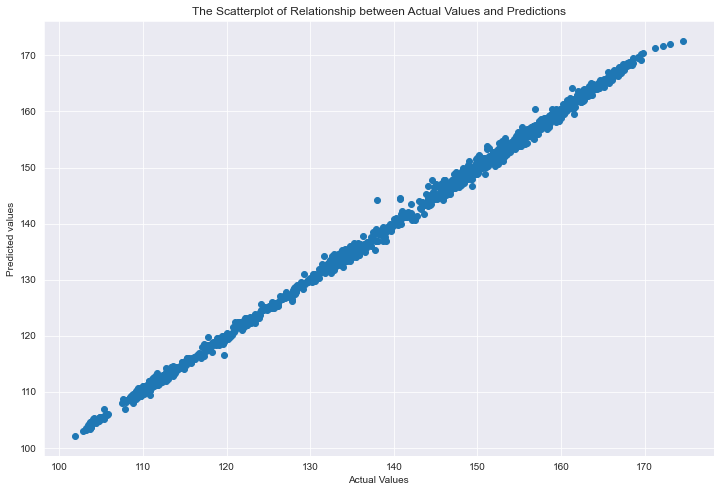

In [81]:
plt.figure(figsize=(12,8))
plt.xlabel("Actual Values")
plt.ylabel("Predicted values")
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.scatter(predictions_df['Actual'], predictions_df['Predicted'])

In [82]:
# We will evaluate our model performance by calculating the residual sum of squares and the explained variance score
from sklearn import metrics
print("MAE:",metrics.mean_absolute_error(y_test,y_predict_test))
print ("MSE:",metrics.mean_squared_error(y_test,y_predict_test))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_predict_test)))

MAE: 0.40227512024818607
MSE: 0.3223665757239999
RMSE: 0.5677733489025352


In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_predict_test = model.predict(x_test_scaled)
y_predict_train = model.predict(x_train_scaled) 
print('R2_score (train): ',r2_score(y_train, y_predict_train))
print('R2_score (test): ',r2_score(y_test, y_predict_test))

376/376 [==============================] - 0s 847us/step
R2_score (train):  0.9986428196499482
R2_score (test):  0.9987125401657745


In [84]:
#Evaluation of  the explained variance score (R^2)
print('This shows our model predict % {} of the target correctly'.
      format(np.round(metrics.explained_variance_score(y_test,y_predict_test)*100,2))) 

This shows our model predict % 99.87 of the target correctly


## Residual Analysis 

<AxesSubplot:ylabel='Density'>

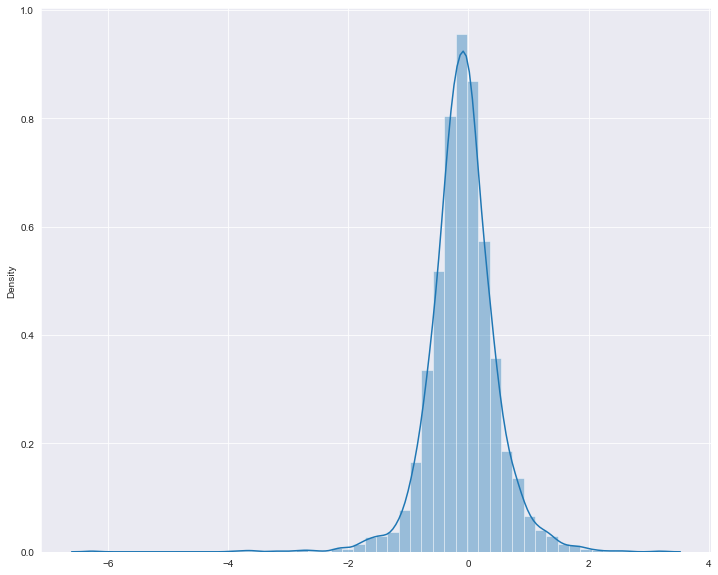

In [85]:
# Now we will visualize the differences between our predictions and actual y test data
plt.figure(figsize=(12,10))
sns.distplot(y_test-y_predict_test,bins=50) #this figure also proves that our model fits very good
#There is no huge differences between our predictions and actual y data

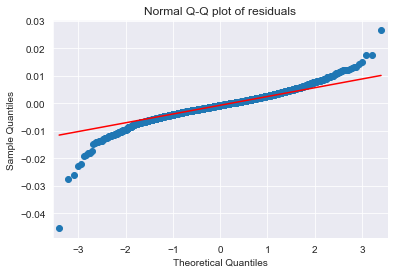

In [86]:
#Residuals values  = y - yhat
import statsmodels.api as smf
smf.qqplot(predictions_df['Error'], line = 'q')
plt.title('Normal Q-Q plot of residuals')
plt.show()